In [1]:
import sys
sys.path.append('/g/data1a/e14/as3189/OFAM/scripts/')
import gsw
import numpy as np
import xarray as xr
from scipy import stats
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from main import paths, idx_1d, LAT_DEG, lx, open_tao_data
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LinearSegmentedColormap
# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath, tpath = paths()
lons = lx['lons']

# Plot multiple subplots

In [51]:
# def plot_tao_timeseries(ds, interp='', T=1, new_end_v=None):
#     """ Plots TAO/TRITION velocity as a function of depth and time at
#     three longitudes: 165°E, 190°E (170°W) and 220°E (140°W).
#     Original data or interpolated data can be plotted.

#     Parameters
#     ----------
#     ds : list
#         List of three TAO xarray datasets.
#     interp : {'', 'linear', 'nearest'}
#         Interpolation method. The default is '' for no interpolation.
#     T : {0, 1}, optional
#         Data frequency to open (daily or monthly). The default is 1.
#     new_end_v : int, optional
#         Velocity [m/s] to replace deepest missing velocity value
#         (usually 0.1 m/s for linear interp). The default is None.

#     Returns
#     -------
#     None.

#     """
#     fig = plt.figure(figsize=(18, 6))
#     for i, lon, du in zip(range(3), lx['lons'], ds):
#         interpx = interp + str(new_end_v) if new_end_v else interp
#         save_name = 'tao_{}_{}.png'.format(interpx, lx['frq'][T])
#         interpx = '({})'.format(interpx) if interp != '' else ''
#         name = '{}TAO/TRITION {} EUC at 0°S,{}°E {}'.format(lx['l'][i],
#                                                             lx['frq_long'][T],
#                                                             lon, interpx)

#         # Plot TAO/TRITION zonal velocity timeseries without any interpolation.
#         if interp == '':
#             plot_eq_velocity(fig, du.depth, du.time,
#                              du.u_1205.transpose('depth', 'time'), i+1, name)
#             save_name = 'tao_original_{}.png'.format(lx['frq'][T])

#         # Plot TAO/TRITION zonal velocity time series with interpolation.
#         else:
#             if new_end_v:
#                 for n in range(len(du.u_1205[:, 0])):
#                     # Replace top level NaN velocities with zero.
#                     if np.isnan(du.u_1205[n, 0]):
#                         du.u_1205[n, 0] = 0
#                     # Replace bottom level NaN with specified velocity.
#                     if np.isnan(du.u_1205[n, -1]):
#                         du.u_1205[n, -1] = new_end_v
#             u_mask = np.ma.masked_invalid(du.u_1205)
#             tt, zz = np.meshgrid(du.depth, np.arange(len(du.time)))
#             t1, z1 = tt[~u_mask.mask], zz[~u_mask.mask]
#             u_masked = u_mask[~u_mask.mask]
#             gn = interpolate.griddata((t1, z1), u_masked.ravel(),(tt, zz),
#                                       method=interp)
#             plot_eq_velocity(fig, du.depth, du.time, np.transpose(gn),
#                              i+1, name)

#     plt.tight_layout()
#     plt.savefig(fpath.joinpath('tao', save_name))
#     plt.show()

#     return


In [52]:
T = 1
ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(10, 360))

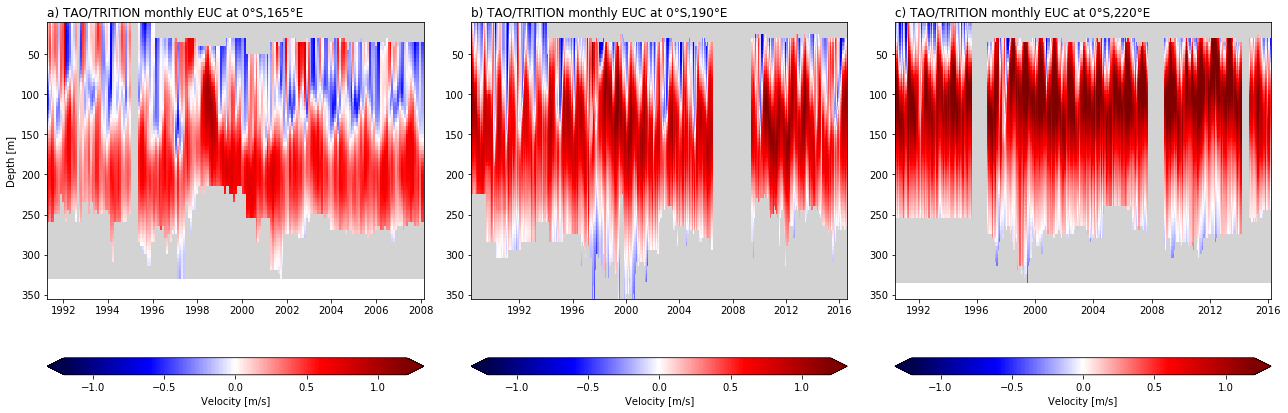

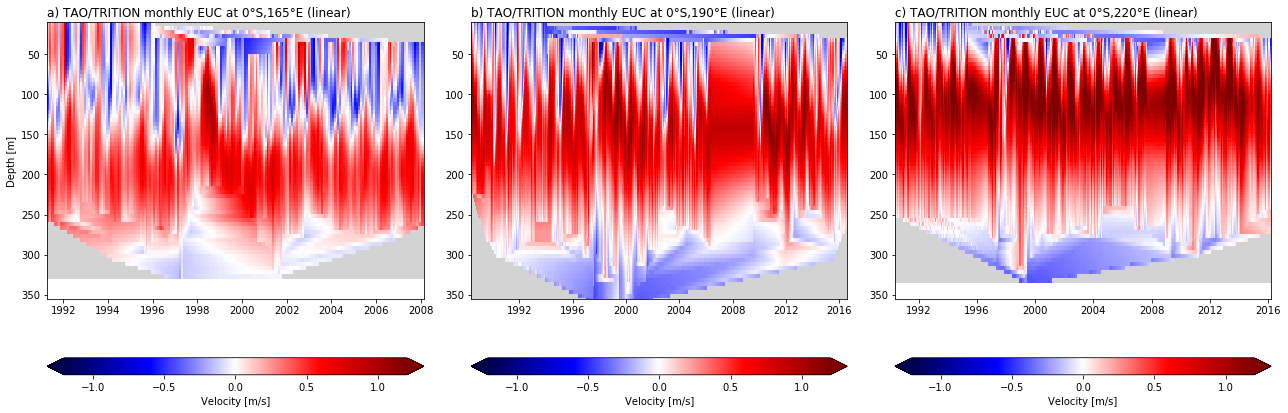

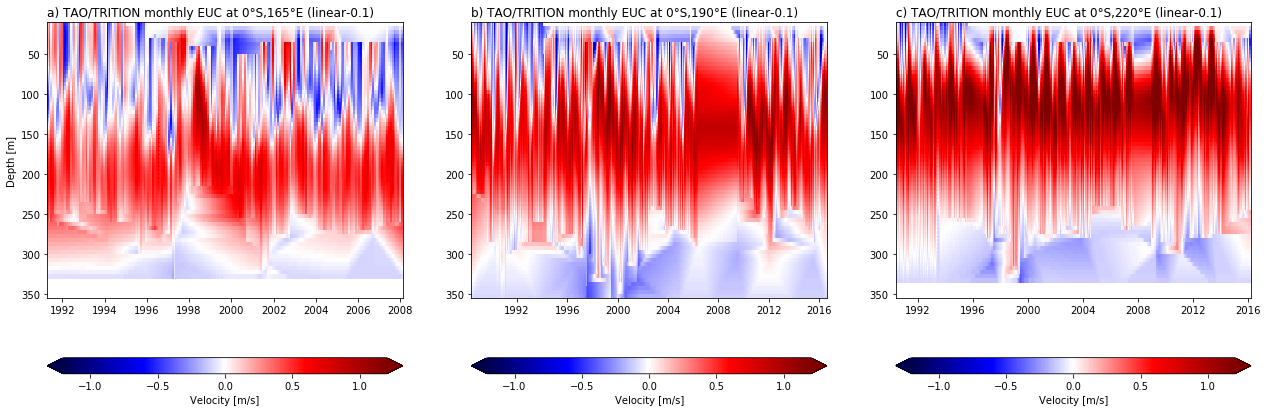

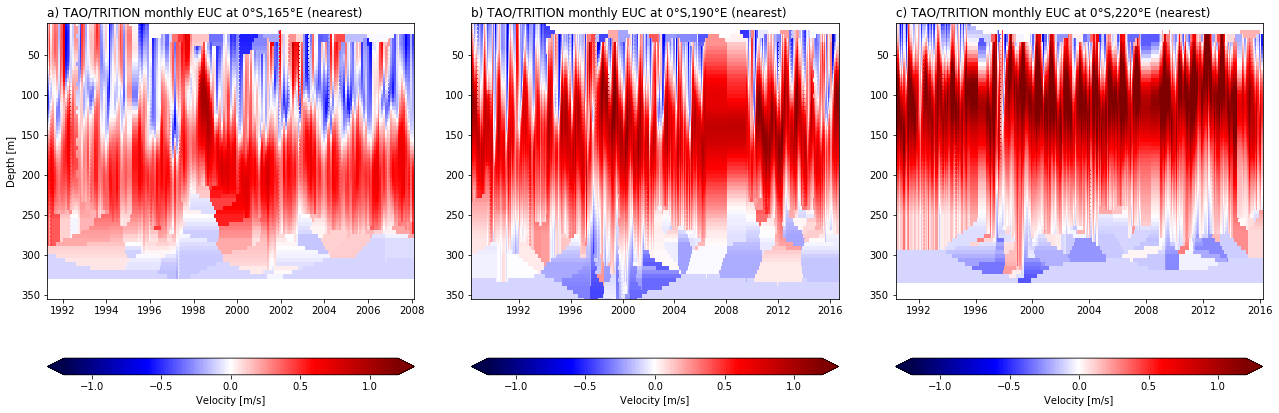

In [53]:
for interp, new_end_v in zip(['', 'linear', 'linear', 'nearest'], [None, None, -0.1, None]):
     plot_tao_timeseries(ds, interp, T=T, new_end_v=new_end_v)

# Finding max velocity at each time ste

# Regression: Max velocity and bottom depth

In [41]:
# def lower_depths(du, i, min_v=0.05, eps=0.025, index=True):
#     u = np.ma.masked_invalid(du)
#     amx = np.nanargmax(u, axis=1)
#     umx = np.nanmax(u, axis=1)
#     amx = np.ma.masked_where(amx == 0, amx)
#     amn = amx.copy()*np.nan
#     depths = amx.copy()*np.nan
#     idepths = amx.copy()*np.nan
#     count = 0
#     empty = 0
#     for t in range(du.shape[0]):
#         # Make sure entire slice isn't all empty.
#         if not (u[t] == True).mask.all() and not np.ma.is_masked(amx[t]):

#             # Find deepest velocity depth index.
#             end = np.ma.nonzero(u[t])[-1][-1]
#             # Search from the lowest depth to the location of max velocity depth.
#             for z in np.arange(end, amx[t], -1):
#                 # Make sure the end value isn't too much larger than v_min.
#                 if u[t, z] >= min_v + eps and z == end:
#                     break
#                 # Find the depth index where velocity starts to be larger than v_min.
#                 if u[t, z] >= min_v:
#                     # Find the velocity is closest to v_min (in the subset array).
#                     tmp = u[t, idx_1d(u[t, z-1:], min_v) + z-1]
#                     # Find the depth index of the cloest velocity (in the full array).
#                     amn[t] = np.argwhere(u[t] == tmp)[-1][-1]
#                     # Find that depth.
#                     depths[t] = du.depth[int(amn[t])]
#                     count += 1
#                     break
#         else:
#             empty += 1
#     print('{}: Min velocity={}, included={}, total={}, skipped={}, Empty={}, eps={}'
#           .format(lons[i], min_v, count, du.shape[0], du.shape[0] - count - empty,  empty, eps))
#     if index == False:
#         return umx, depths
#     else:
#         return umx, amn

# def EUC_depths(u, depths, i, v_bnd=0.05, eps=0.005, tao=True, index=False):
#     if tao:
#         u = np.ma.masked_invalid(u)
#     # Maximum velocity at each time.
#     v_max = np.nanmax(u, axis=1)  # umx
#     v_min = np.nanmin(u, axis=1)
#     # Index of maximum velocity at each time.
#     v_imax = np.nanargmax(u, axis=1)  # amx
#     v_ibnd = np.nanargmax(u, axis=1)  # amn
#     # Depth of maximum velocity.
#     depth_vmax = v_imax.copy()*np.nan  # mn_depth
#     # Bottom depth levels (based on minimum velocity bound for the EUC).
#     depth_bnd = v_imax.copy()*np.nan  # mx_depth
#     count = 0
#     # Find deepest velocity depth index.
#     end = len(depths) - 1
#     empty=0
#     for t in range(u.shape[0]):
#         # Make sure entire slice isn't all empty.
#         if not (u[t] == True).mask.all() and not np.ma.is_masked(v_imax[t]):
#             # Find depth of maximum velocity.
#             depth_vmax[t] = depths[int(v_imax[t])].item()
#             if tao:
#                 # Find deepest velocity depth index.
#                 end = np.ma.nonzero(u[t])[-1][-1]
#             for z in np.arange(end, v_imax[t], -1):
#                 # Make sure the end value isn't too much larger than v_min.
#                 if u[t, z] >= v_bnd + eps and z == end:
#                     break
#                 # Find depth index where velocity starts to be larger than v_min.
#                 if u[t, z] >= v_bnd:
#                     # Find velocity closest to v_bnd in the subset array.
#                     tmp = u[t, idx_1d(u[t, z-1:], v_bnd) + z-1].item()
#                     # Find depth index of the closet velocity (in the full array).
#                     v_ibnd[t] = np.argwhere(u[t] == tmp)[-1][-1]
#                     # Find that depth.
#                     depth_bnd[t] = depths[int(v_ibnd[t])]
#                     count += 1
#                     break
#         else:
#             empty += 1
    
#     print('{}: Min velocity={}, included={}, total={}, skipped={}, Empty={}, eps={}'
#           .format(lx['lons'][i], v_bnd, count, u.shape[0], u.shape[0] - count - empty,  empty, eps))    
#     if not index:
#         return v_max, depth_vmax, depth_bnd
#     else:
#         return v_max, vimax, v_ibnd


# def cor_scatter_plot(fig, i, v_max, depths, name=None):
#     var0 = v_max[np.ma.nonzero(depths)]
#     var1 = depths[np.ma.nonzero(depths)]
#     var0 = var0[~np.isnan(var1)]
#     var1 = var1[~np.isnan(var1)]
#     cor = stats.spearmanr(var0, var1)
#     print(cor)
#     slope, intercept, r_value, p_value, std_err = stats.linregress(var0, var1)
#     print('slope={:.2f}, intercept={:.2f}, r_value={:.2f}, p_value={:.2f}, std_err={:.2f}'
#           .format(slope, intercept, r_value, p_value, std_err))
    
#     ax = fig.add_subplot(1, 3, i)
#     ax.set_title(name, loc='left')
#     ax.scatter(v_max, depths, color='b', s=8)

#     atext = AnchoredText('$\mathregular{r_s}$=' + str(np.around(cor[0], 2)) + 
#                          ', p=' + str(np.around(cor[1], 3)), loc=3)
#     ax.add_artist(atext)
#     ax.plot(np.unique(var0), np.poly1d(np.polyfit(var0, var1, 1)) (np.unique(var0)), 'k')
#     line = slope*var0 + intercept
#     plt.plot(var0, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))
#     ax.set_xlabel('Maximum velocity [m/s]')
#     ax.set_ylabel('Depth [m]')
#     ax.legend(fontsize=9)
#     return 

Correlating max depth and max velocity at 165°E
165: Min velocity=0.05, included=38, total=203, skipped=160, Empty=5, eps=0.005
SpearmanrResult(correlation=-0.27770959743881507, pvalue=7.458074493976686e-05)
slope=-65.48, intercept=209.25, r_value=-0.19, p_value=0.01, std_err=24.50
Correlating max depth and max velocity at 190°E
190: Min velocity=0.05, included=135, total=340, skipped=169, Empty=36, eps=0.005
SpearmanrResult(correlation=-0.5075804180040542, pvalue=2.6003670264624397e-21)
slope=-52.85, intercept=186.74, r_value=-0.38, p_value=0.00, std_err=7.37
Correlating max depth and max velocity at 220°E
220: Min velocity=0.05, included=146, total=311, skipped=134, Empty=31, eps=0.005
SpearmanrResult(correlation=-0.5950102727143469, pvalue=3.3193904871149367e-28)
slope=-46.89, intercept=160.57, r_value=-0.58, p_value=0.00, std_err=3.92
Correlating lower depth and max velocity at 165°E
165: Min velocity=0.05, included=38, total=203, skipped=160, Empty=5, eps=0.005
SpearmanrResult(cor

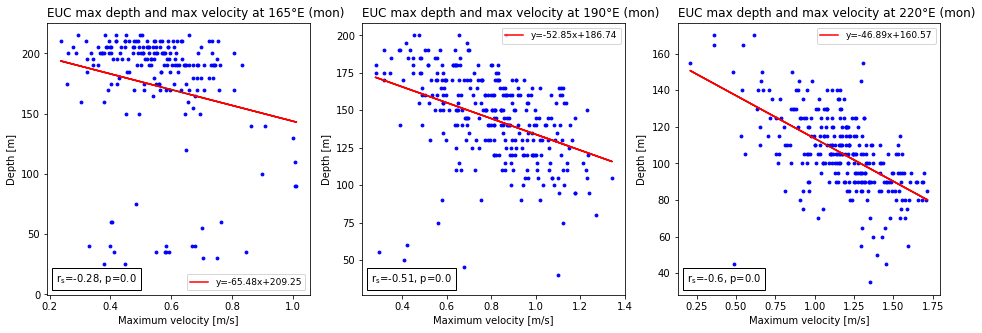

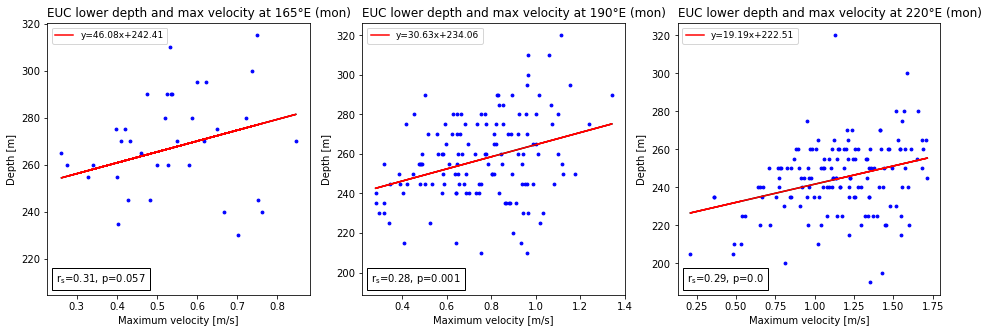

In [42]:
# for loc in ['max', 'lower']:
#     fig = plt.figure(figsize=(16, 5))
#     for i, du in enumerate(ds):
#         print('Correlating {} depth and max velocity at {}°E'.format(loc, lx['lons'][i]))
#         name = 'EUC {} depth and max velocity at {}°E ({})'.format(loc, lx['lons'][i], lx['frq'][T])
#         if loc == 'max':
#             umx, depths, depth_end = EUC_depths(du.u_1205, du.depth, i, v_bnd=0.05, eps=0.005, tao=True)
#         elif loc == 'lower':
#             umx, depth_max, depths = EUC_depths(du.u_1205, du.depth, i, v_bnd=0.05, eps=0.005, tao=True)

#         cor_scatter_plot(fig, i+1, umx, depths, name=name)
#     plt.savefig(fpath.joinpath('tao', 'max_velocity_{}_depth_cor_{}.png'.format(loc, lx['frq'][T])))

165: Min velocity=0.1, included=86, total=203, skipped=112, Empty=5, eps=0.05
190: Min velocity=0.1, included=200, total=340, skipped=104, Empty=36, eps=0.05
220: Min velocity=0.1, included=232, total=311, skipped=48, Empty=31, eps=0.05


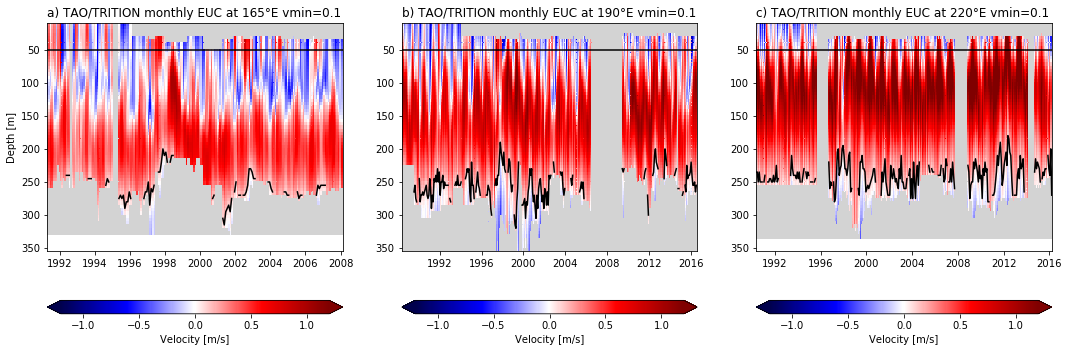

165: Min velocity=0.01, included=28, total=203, skipped=169, Empty=6, eps=0.005
190: Min velocity=0.01, included=107, total=340, skipped=197, Empty=36, eps=0.005
220: Min velocity=0.01, included=109, total=311, skipped=171, Empty=31, eps=0.005

165: Min velocity=0.05, included=51, total=203, skipped=146, Empty=6, eps=0.025
190: Min velocity=0.05, included=153, total=340, skipped=151, Empty=36, eps=0.025
220: Min velocity=0.05, included=167, total=311, skipped=113, Empty=31, eps=0.025

165: Min velocity=0.075, included=67, total=203, skipped=130, Empty=6, eps=0.038
190: Min velocity=0.075, included=182, total=340, skipped=122, Empty=36, eps=0.038
220: Min velocity=0.075, included=196, total=311, skipped=84, Empty=31, eps=0.038

165: Min velocity=0.1, included=86, total=203, skipped=111, Empty=6, eps=0.05
190: Min velocity=0.1, included=200, total=340, skipped=104, Empty=36, eps=0.05
220: Min velocity=0.1, included=232, total=311, skipped=48, Empty=31, eps=0.05

# Interpolating OFAM3 depth to every 5 m


In [23]:
du = ds[1].u_1205
t = -1
y = du[t].values
x = du[t].depth.values

f = interpolate.interp1d(x, y, kind='slinear')
z = np.arange(10, x[-1]+1, 5)
f(z)

array([        nan,         nan,         nan,         nan, -0.2241077 ,
       -0.10729849, -0.06175052, -0.01560109,  0.03550928,  0.09280071,
        0.16594538,  0.24883835,  0.34268868,  0.4464438 ,  0.55731237,
        0.67626542,  0.78920561,  0.88975161,  0.95700026,  0.99680716,
        1.0050714 ,  0.98722261,  0.95742345,  0.92072505,  0.88559896,
        0.8523742 ,  0.81850386,  0.78312469,  0.74442291,  0.70517695,
        0.66717863,  0.63181657,  0.60003513,  0.5681082 ,  0.53437793,
        0.49205089,  0.44270709,  0.38866565,  0.3367244 ,  0.29194206,
        0.25647962,  0.22806311,  0.20708391,  0.18962742,  0.1756864 ,
        0.16114131,  0.14590985,  0.12908368,  0.11358575,  0.09936476,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [24]:
files = []
for y in range(lx['years'][0][0], lx['years'][0][1]+1):
    for m in range(1, 13):
        files.append(str(xpath.joinpath('ocean_u_{}_{:02d}.nc'.format(y, m))))

In [27]:
df = xr.open_mfdataset(files, combine='by_coords')

In [369]:
df.st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 51)>
array([   2.5     ,    7.5     ,   12.5     ,   17.51539 ,   22.667021,
         28.16938 ,   34.218006,   40.954975,   48.454975,   56.718006,
         65.66938 ,   75.167023,   85.015388,   95.      ,  105.      ,
        115.      ,  125.      ,  135.      ,  145.      ,  155.      ,
        165.      ,  175.      ,  185.      ,  195.      ,  205.189896,
        217.054489,  233.194321,  255.884232,  286.608978,  325.884216,
        373.194336,  427.054474,  485.189911,  545.511108,  610.415649,
        685.926758,  775.926758,  880.415649,  995.511108, 1115.313354,
       1238.353882, 1368.157471, 1507.733887, 1658.157471, 1818.353882,
       1985.313354, 2165.180176, 2431.101074, 2894.841797, 3603.101074,
       4509.180176])
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:      

In [22]:
df = df.sel(xu_ocean=[165, 190, 220], yu_ocean=slice(-2.6, 2.6), st_ocean=slice(2.5, 485))
# Calculate the monthly mean.
df = ds.resample(Time="MS").mean()
# New depth levels to interpolate to.
z = np.arange(10, 360, 5)


In [23]:
di = df.interp(st_ocean=z, method='slinear')
# di = df.interp(st_ocean=z, method='cubic')

[0.46271968 0.46586996 0.45597607 0.43525302 0.39988112 0.34530216
 0.27098468 0.1903272  0.135768  ]
[-0.60045663 -0.58711087 -0.57451055 -0.56089287 -0.54670889 -0.5327543
 -0.52091785 -0.51206265 -0.5045967  -0.49866349 -0.491622   -0.48400037
 -0.47147061 -0.4581822  -0.44004657 -0.42174343 -0.3951818  -0.36859468
 -0.33427121 -0.29994774 -0.25206812 -0.2041885  -0.12318155 -0.0421746
  0.0514483   0.14507121  0.19037151  0.2356718   0.27720649  0.31874117
  0.35463491  0.39052865  0.41509114  0.43965364  0.45118666  0.46271968
  0.46429482  0.46586996  0.46101521  0.45616045  0.4475746   0.43884145
  0.42879767  0.41783972  0.40688177  0.39553769  0.38351055  0.37148341
  0.35945626  0.34742912  0.33534688  0.32325281  0.31115873  0.29906465
  0.28697058  0.2748765   0.26402072  0.25375248  0.24348425  0.23321601
  0.22294777  0.21267954  0.2024113   0.19214307  0.18558077  0.17981465
  0.17404853  0.1682824   0.16251628  0.15675015]


[        nan -0.58711087 -0.57451055 -0.56089287 -0.54670889 -0.5327543
 -0.52091785 -0.51206265 -0.5045967  -0.49866349 -0.491622   -0.48400037
 -0.47147061 -0.4581822  -0.44004657 -0.42174343 -0.3951818  -0.36859468
 -0.33427121 -0.29994774 -0.25206812 -0.2041885  -0.12318155 -0.0421746
  0.0514483   0.14507121  0.19037151  0.2356718   0.27720649  0.31874117
  0.35463491  0.39052865  0.41509114  0.43965364  0.45118666  0.46271968
  0.46429482  0.46586996  0.46101521  0.45616045  0.4475746   0.43884145
  0.42879767  0.41783972  0.40688177  0.39553769  0.38351055  0.37148341
  0.35945626  0.34742912  0.33534688  0.32325281  0.31115873  0.29906465
  0.28697058  0.2748765   0.26402072  0.25375248  0.24348425  0.23321601
  0.22294777  0.21267954  0.2024113   0.19214307         nan         nan
         nan         nan         nan         nan]


# Calculating transport

In [11]:
# Area = metres in a degree of latitude x cell width x cell depth
area = LAT_DEG*0.1*5

# Multiply each grid cell by the constant.
dt = (di*area).sum(dim='yu_ocean').u.sel(st_ocean=slice(10, 355))
dt

# Plot OFAM3 EUC velocity at the equator

In [4]:
d3 = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
d3

<xarray.Dataset>
Dimensions:   (Time: 384, st_ocean: 70, xu_ocean: 3)
Coordinates:
  * Time      (Time) datetime64[ns] 1981-01-01 1981-02-01 ... 2012-12-01
  * xu_ocean  (xu_ocean) float64 165.0 190.0 220.0
  * st_ocean  (st_ocean) int64 10 15 20 25 30 35 40 ... 330 335 340 345 350 355
    yu_ocean  float64 ...
Data variables:
    uvo       (Time, st_ocean, xu_ocean) float32 ...
    u         (Time, st_ocean, xu_ocean) float32 ...

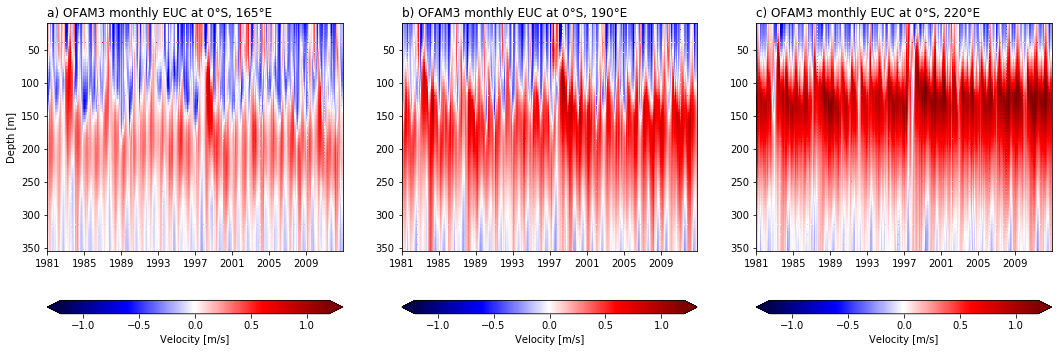

In [9]:
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    dq = d3.sel(xu_ocean=lx['lons'][i])
    name = '{}OFAM3 {} EUC at 0°S, {}°E '.format(lx['l'][i], lx['frq_long'][T], lx['lons'][i])
    u = dq.u.transpose('st_ocean', 'Time')
    plot_eq_velocity(fig, dq.st_ocean, dq.Time , u, i+1, name, max_depth=355)
save_name = 'ofam3_interp.png'
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

# Calculate OFAM3 transport

In [6]:
# def EUC_depths(u, i, min_v=0.05, eps=0.005):
#     amx = np.argmax(u, axis=1)
#     umx = np.max(u, axis=1)
#     amn = amx.copy()*np.nan
#     mx_depth = amx.copy()*np.nan
#     mn_depth = amx.copy()*np.nan
#     count = 0
#     # Find deepest velocity depth index.
#     end = len(dt.st_ocean) -1
#     for t in range(u.shape[0]):
#         # Find depth of maximum velocity.
#         mx_depth[t] = u.st_ocean[int(amx[t])].item()
        
#         for z in np.arange(end, amx[t], -1):
#             # Make sure the end value isn't too much larger than v_min.
#             if u[t, z] >= min_v + eps and z == end:
#                 break
#             # Find the depth index where velocity starts to be larger than v_min.
#             if u[t, z] >= min_v:
#                 # Find the velocity is closest to v_min (in the subset array).
#                 tmp = u[t, idx_1d(u[t, z-1:], min_v) + z-1].item()
#                 # Find the depth index of the cloest velocity (in the full array).
#                 amn[t] = np.argwhere(u[t].values == tmp)[-1][-1]
#                 # Find that depth.
#                 mn_depth[t] = u.st_ocean[int(amn[t])]
#                 count += 1
#                 break
#     print('{}E: Min velocity={}, included={}, total={}, skipped={}, eps={}'
#           .format(lons[i], min_v, count, u.shape[0], u.shape[0] - count, eps))

#     return umx, mx_depth, mn_depth

165E: Min velocity=0.1, included=362, total=384, skipped=22, eps=0.05
190E: Min velocity=0.1, included=334, total=384, skipped=50, eps=0.05
220E: Min velocity=0.1, included=360, total=384, skipped=24, eps=0.05


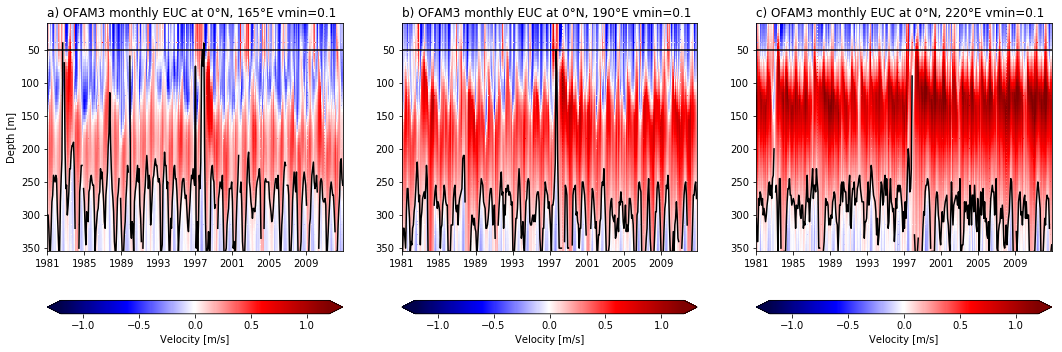

In [32]:
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    dq = d3.sel(xu_ocean=lon)
    name = '{}OFAM3 {} EUC at 0°N, {}°E vmin={}'.format(lx['l'][i], lx['frq_long'][T], lon, min_v)
    z = dq.st_ocean
    t = dq.Time 
    u = dq.u.transpose('st_ocean', 'Time')
    ax = plot_eq_velocity(fig, z, t, u, i+1, name, max_depth=355)
    umx, mx_depth, mn_depth = EUC_depths(dq.u, dq.st_ocean, i, v_bnd=min_v, eps=eps)
    ax.plot(t, mn_depth, 'k')
    ax.axhline(50, color='k')
save_name = 'ofam3_interp_bounds_{}.png'.format(min_v)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

165: Min velocity=0.01, included=232, total=384, skipped=152, eps=0.005
190: Min velocity=0.01, included=188, total=384, skipped=196, eps=0.005
220: Min velocity=0.01, included=224, total=384, skipped=160, eps=0.005

165: Min velocity=0.05, included=301, total=384, skipped=83, eps=0.025
190: Min velocity=0.05, included=264, total=384, skipped=120, eps=0.025
220: Min velocity=0.05, included=296, total=384, skipped=88, eps=0.025

165: Min velocity=0.1, included=362, total=384, skipped=22, eps=0.05
190: Min velocity=0.1, included=334, total=384, skipped=50, eps=0.05
220: Min velocity=0.1, included=360, total=384, skipped=24, eps=0.05

# Comparing OFAM3 with TAO plots

In [15]:
time_bnds_ofam = [[10*12+3, 27*12+1], [7*12+4, -1], [9*12+4, -1]]
time_bnds_tao = [[0, -1], [0, 24*12+8], [0, 22*12+8]]
print(2014-1990)
for i, du in enumerate([du_165, du_190, du_220]):
    du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))
    ti = du.time[0]
    tf = du.time[-1]
    print(lons[i], ti, tf)
#     print(du.time[24*12+7])
# print(dt.Time[9*12+4])
# [1991-04-16, 2008-02-15] 
# [1988-05-16, 2016-08-16]
# [1990-05-16, 2016-03-16]

24
165 <xarray.DataArray 'time' ()>
array('1991-04-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1991-04-16T12:00:00
    lat      float32 0.0
    lon      float32 165.0
Attributes:
    FORTRAN_format:  
    type:            UNEVEN
    point_spacing:   uneven <xarray.DataArray 'time' ()>
array('2008-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2008-01-16T12:00:00
    lat      float32 0.0
    lon      float32 165.0
Attributes:
    FORTRAN_format:  
    type:            UNEVEN
    point_spacing:   uneven
190 <xarray.DataArray 'time' ()>
array('1988-05-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1988-05-16T12:00:00
    lat      float32 0.0
    lon      float32 190.0
Attributes:
    FORTRAN_format:  
    type:            UNEVEN
    point_spacing:   uneven <xarray.DataArray 'time' ()>
array('2012-12-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:

In [49]:
def plot_tao(fig, z, t, u, i, name, max_depth=325, rows=1):
    cmap = plt.cm.RdBu_r
    cmap.set_bad('lightgrey') 
    ax = fig.add_subplot(rows, 3, i)
    ax.set_title(name, loc='left', fontsize=16)
    im = ax.pcolormesh(t, z, u, cmap=cmap, vmax=1.20, vmin=-1.20)
    ax.set_ylim(max_depth, 10)
    
    if rows == 1:
        plt.colorbar(im, shrink=1, orientation='horizontal', extend='both')
    elif rows == 2 and i == 6:
#         cbar_ax = fig.add_axes([0.33, 0.05, 0.33, 0.03])
#         cbar = plt.colorbar(im, cax=cbar_ax, shrink=1, orientation='horizontal', extend='both')
#         cbar.set_label('Zonal velocity [m/s]')
        cbar_ax = fig.add_axes([0.925, 0.11, 0.019, 0.355])
#     [left, bottom, width, height]
        cbar = plt.colorbar(im, cax=cbar_ax, shrink=1, orientation='vertical', extend='both')
        cbar.set_label('Zonal velocity [m/s]')
    if i == 1 or i == 4:
        ax.set_ylabel('Depth [m]')
    #Add separate colourbar axes (left, bottom, width, height)
    return ax

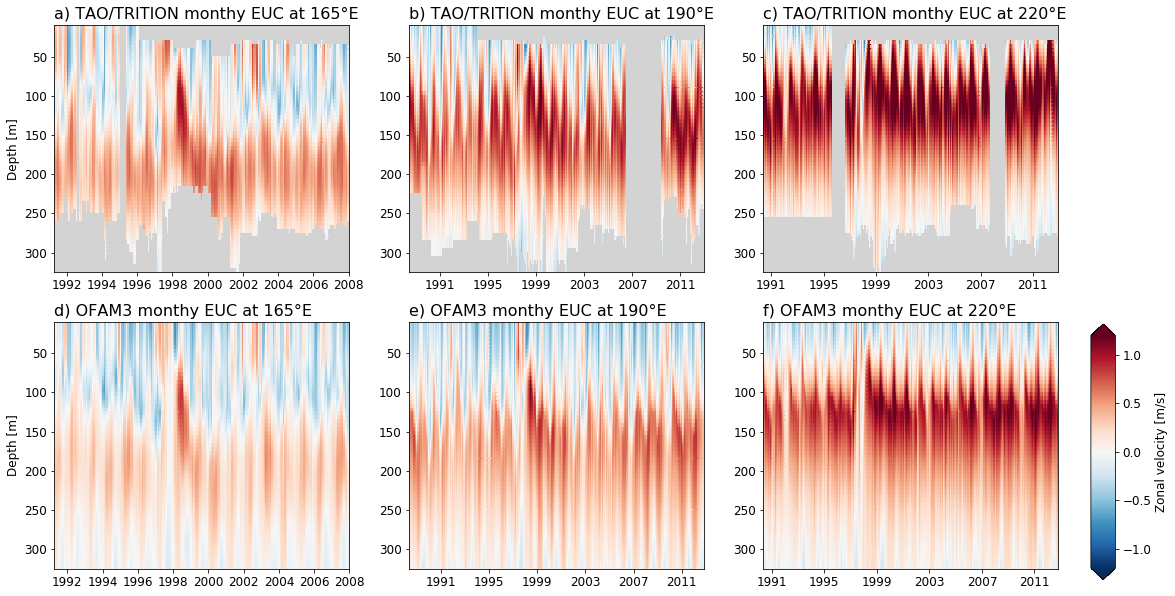

In [50]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 12})
plt.rcParams['savefig.dpi'] = 300
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)
fig = plt.figure(figsize=(18, 10))

for i, lon in enumerate(lons):
    du = [du_165, du_190, du_220][i]
    du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))
    name = '{}TAO/TRITION {} EUC at {}°E'.format(lx['l'][i], freq, lon)
    z = du.depth
    t = du.time 
    u = du.transpose('depth', 'time')
    ax = plot_tao(fig, z, t, u, i+1, name, rows=2)
#     umx, depths = lower_depths(du, i, min_v=min_v, eps=eps)
#     ax.plot(t, depths, 'k')
#     ax.axhline(50, color='k')
    
for i, lon in enumerate(lons):
    dq = dt.sel(xu_ocean=lon)
    dq = dq.isel(Time=slice(time_bnds_ofam[i][0], time_bnds_ofam[i][1]))
    name = '{}OFAM3 {} EUC at {}°E '.format(lx['l'][i+3], freq, lon)
    z = dq.st_ocean
    t = dq.Time 
    u = dq.u.transpose('st_ocean', 'Time')
    ax = plot_tao(fig, z, t, u, i+4, name, rows=2)
#     umx, mx_depth, mn_depth = EUC_depths(dq.u, i, min_v=min_v, eps=eps)
#     ax.plot(t, mn_depth, 'k')
#     ax.axhline(50, color='k')

save_name = 'tao_ofam_depths_{}_bounds_{}.png'.format(freqx, min_v)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

In [627]:
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)

for i, lon in enumerate(lons):
    du = [du_165, du_190, du_220][i]
    lon=lons[i]
    du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1])).sel(depth=slice(50, 355))
    umx, depths = lower_depths(du, i, min_v=min_v, eps=eps, index=True)
    tmp = np.ma.where(np.isnan(depths) == False)[0]
    xp = du.sel(depth=50).copy()*np.nan
    xp_165 = xp.copy()
    xp_190 = xp.copy()
    xp_220 = xp.copy()
    for t in tmp:
        r = du[t, 0:int(depths[t])+1]*5
        r = r.where(r > 0, 0)
        xp[t] = np.sum(r).item()
    if i == 0:
        xp_165 = xp
    elif i == 1:
        xp_190 = xp
    elif i == 2:
        xp_220 = xp

165: Min velocity=0.1, included=74, total=202, skipped=107, Empty=21, eps=0.05
190: Min velocity=0.1, included=167, total=296, skipped=88, Empty=41, eps=0.05
220: Min velocity=0.1, included=200, total=272, skipped=43, Empty=29, eps=0.05


In [619]:

t=15636501 
print(depths[t], du.depth[t].item(), du[t, int(depths[t])].item())
r = du[t, 0:int(depths[t])+1]*5
r = r.where(r > 0, 0)
np.sum(r).item()

41.0 125.0 0.08906452357769012


84.93547821044922

In [626]:
xp*230*1000/1e6

<xarray.DataArray 'u_1205' (time: 296)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 24.04854  ,
       19.53516  , 22.334856 , 22.086304 ,        nan,        nan,
        5.3279314,  7.802441 , 10.47663  , 18.80938  , 23.878302 ,
       31.664022 , 29.151312 , 19.522327 , 15.455922 , 17.53414  ,
       18.130404 , 10.892059 ,  5.434436 , 10.715124 , 24.181532 ,
       24.1427   , 28.36451  , 19.023281 , 23.589392 , 17.431252 ,
       12.172214 ,  6.5705805,        nan, 10.84821  , 10.390587 ,
       10.881854 , 14.510607 , 16.015322 , 24.42754  , 22.541744 ,
       25.633165 , 21.182425 , 20.113651 , 15.146779 ,        nan,
       12.418961 ,  9.779358 ,        nan,        nan, 17.315077 ,
              nan, 21.203625 , 19.801292 , 20.027351 ,  9.334474 ,
       15.518783 , 12.924306 , 15.432197 , 11.831008 ,        nan,
              nan,    